In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import tensorflow_hub as hub

# Load the ID card image
id_card_image = cv2.imread('/content/id1.jpg')
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Convert the ID card image to grayscale
gray_id_card = cv2.cvtColor(id_card_image, cv2.COLOR_BGR2GRAY)

# Detect faces using the face classifier
faces = face_classifier.detectMultiScale(gray_id_card, scaleFactor=1.3, minNeighbors=10)

# When no faces are detected, face_classifier returns an empty tuple
if len(faces) == 0:
    print("No faces found in ID card")
else:
    # Draw rectangles around detected faces on the ID card image
    for (x, y, w, h) in faces:
        x = x - 25  # Padding trick to capture more than just Haarcascades points
        y = y - 40  # Adjusting the position
        cv2.rectangle(id_card_image, (x, y), (x + w + 50, y + h + 70), (27, 200, 10), 2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Load the pre-trained ResNet-50 model from TensorFlow Hub
    resnet_model = hub.load("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5")

    # Open a text file to save features
    features_file = open("muzammal_face_features.txt", "w")

    # Crop and save each detected face from the ID card
    for idx, (x, y, w, h) in enumerate(faces):
        face_roi = id_card_image[y:y + h, x:x + w]

        # Resize the face to a specific size (e.g., 224x224)
        resized_face = cv2.resize(face_roi, (224, 224))

        # Save the enhanced face image
        output_path = f"muzammal_face_{idx}.jpg"
        cv2.imwrite(output_path, resized_face)
        print(f"Face image saved at: {output_path}")

        # Extract features using the ResNet-50 model
        preprocessed_face = tf.image.convert_image_dtype(resized_face, dtype=tf.float32)
        preprocessed_face = tf.image.resize(preprocessed_face, (224, 224))
        preprocessed_face = preprocessed_face[np.newaxis, ...]
        features = resnet_model(preprocessed_face)

        # Save the extracted features as a numpy array
        features_path = f"muzammal_face_features_{idx}.npy"
        np.save(features_path, features.numpy())  # Use .numpy() to convert TensorFlow tensor to numpy array
        print(f"Face features saved at: {features_path}")

        # Save the extracted features to the text file
        features_file.write(f"Face {idx+1} Features:\n")
        features_file.write(str(features.numpy()) + "\n\n")

    # Close the features file
    features_file.close()


Face image saved at: muzammal_face_0.jpg
Face features saved at: muzammal_face_features_0.npy


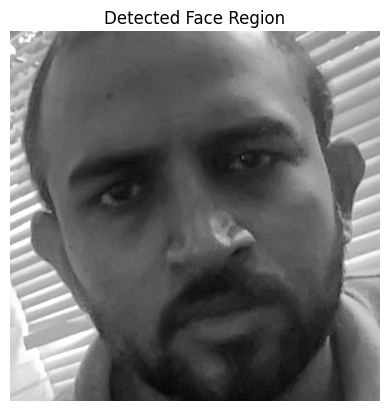

Detected face region image saved at: /content/detected_face_region.jpg
Extracted features saved at: /content/extracted_face_features.npy


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pyplot as plt

# Load the captured photo
captured_image_path = '/content/f4.jpg'
captured_image = cv2.imread(captured_image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(captured_image, cv2.COLOR_BGR2GRAY)

# Load the pre-trained Haarcascades face detection classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces in the grayscale image
faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# If faces are detected, proceed to crop and save the face region
if len(faces) > 0:
    x, y, w, h = faces[0]  # Assuming only one face is detected, you can modify this accordingly
    face_region = gray_image[y:y+h, x:x+w]

    # Display the face region
    plt.imshow(face_region, cmap='gray')
    plt.title("Detected Face Region")
    plt.axis('off')
    plt.show()

    # Save the detected face region image
    detected_face_image_path = '/content/detected_face_region.jpg'
    cv2.imwrite(detected_face_image_path, face_region)
    print("Detected face region image saved at:", detected_face_image_path)

    # Load the pre-trained ResNet-50 model from TensorFlow Hub
    resnet_model = hub.load("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5")

    # Preprocess the face image for the ResNet-50 model
    preprocessed_face = cv2.resize(face_region, (224, 224))  # Resize to 224x224
    preprocessed_face = cv2.cvtColor(preprocessed_face, cv2.COLOR_GRAY2RGB)  # Convert to RGB
    preprocessed_face = tf.image.convert_image_dtype(preprocessed_face, dtype=tf.float32)
    preprocessed_face = preprocessed_face[np.newaxis, ...]

    # Extract features using the ResNet-50 model
    extracted_features = resnet_model(preprocessed_face)

    # Convert the extracted features tensor to a numpy array
    extracted_features_array = extracted_features.numpy()

    # Save the extracted features as a numpy array
    features_output_path = '/content/extracted_face_features.npy'
    np.save(features_output_path, extracted_features_array)
    print("Extracted features saved at:", features_output_path)
else:
    print("No faces detected in the image.")


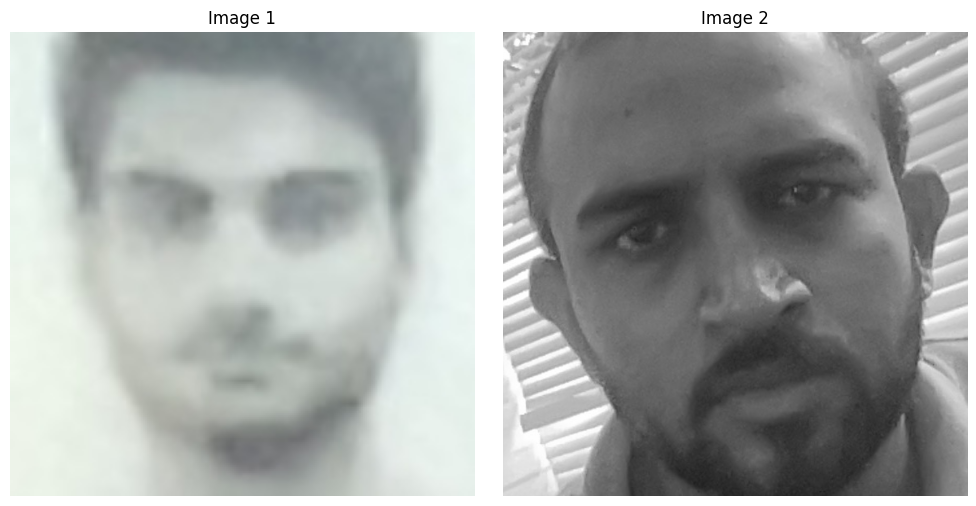

The images are not of the same person (verification failed)
Similarity: 0.5349587798118591


In [ ]:
import cv2
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt

# Load the features from the .npy files
features1_path = '/content/muzammal_face_features_0.npy'
features2_path = '/content/extracted_face_features.npy'

features1 = np.load(features1_path)
features2 = np.load(features2_path)

# Flatten the feature vectors to 1-D arrays
features1 = features1.flatten()
features2 = features2.flatten()

# Calculate the cosine similarity between the flattened feature vectors
similarity = 1 - cosine(features1, features2)

# Hyperparameter: Set a threshold for similarity comparison
similarity_threshold = 0.6  # Adjust as needed

# Load the images for visualization
image1_path = '/content/muzammal_face_0.jpg'
image2_path = '/content/detected_face_region.jpg'

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# Display the images being compared
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title("Image 2")
plt.axis('off')

plt.tight_layout()
plt.show()

# Compare similarity with threshold
if similarity > similarity_threshold:
    print("The images are of the same person (verification successful)")
else:
    print("The images are not of the same person (verification failed)")

print("Similarity:", similarity)
